<a href="https://colab.research.google.com/github/Yussefayman/AI-ART/blob/main/AIART2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

import tarfile, requests, os
fname = 'MNIST.tar.gz'
name = 'mnist'
url = 'https://osf.io/y2fj6/download'
if not os.path.exists(name):
  print('\nDownloading MNIST dataset...')
  r = requests.get(url,allow_redirects=True)
  with open(fname,'wb') as fh:
    fh.write(r.content)
  print('\nDownloading MNIST completed..\n')

if not os.path.exists(name):
  with tarfile.open(fname) as tar:
    tar.extractall(name)
    os.remove(fname)
else:
  print('MNIST dataset has been downloaded.\n')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



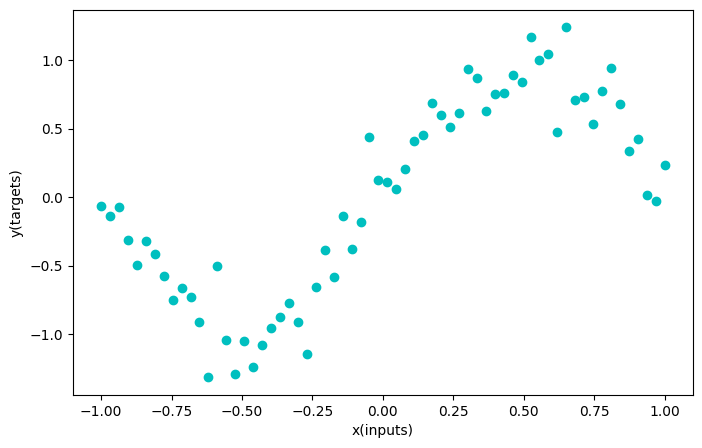

In [2]:
#@title Generating some data (inputs and targets)
n_samples = 64
inputs = torch.linspace(-1.0,1.0,n_samples).reshape(n_samples,1)
noise = torch.randn(n_samples,1) / 5
targets = torch.sin(3.14*inputs) + noise
plt.figure(figsize=(8,5))
plt.scatter(inputs,targets,c='c')
plt.xlabel('x(inputs)')
plt.ylabel('y(targets)')
plt.show()

In [3]:
class WideNet(nn.Module):
  def __init__(self,n_cells=512):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1,n_cells),
        nn.Tanh(),
        nn.Linear(n_cells,1),
    )
  def forward(self,x):
    return self.layers(x)


In [4]:
wide_net = WideNet()

In [5]:
wide_net.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('layers',
               Sequential(
                 (0): Linear(in_features=1, out_features=512, bias=True)
                 (1): Tanh()
                 (2): Linear(in_features=512, out_features=1, bias=True)
               ))])}

In [6]:
print('Input Shape:',inputs.shape)
out = wide_net(inputs)
print('Output shape:',out.shape)
print('PyTorch summary of wn:')
wide_net

Input Shape: torch.Size([64, 1])
Output shape: torch.Size([64, 1])
PyTorch summary of wn:


WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

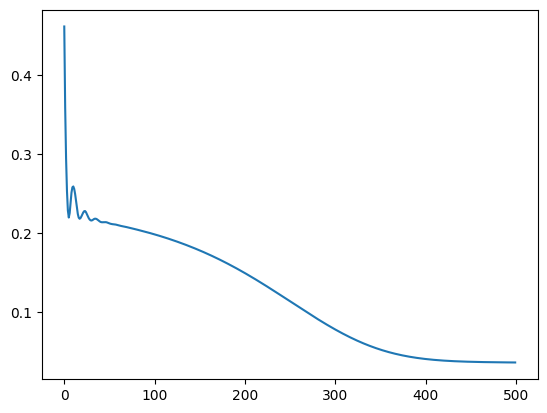

In [7]:
wide_net = WideNet()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(wide_net.parameters(),lr=1e-3)
losses = []
for i in range(500):
  optimizer.zero_grad()
  predictions = wide_net(inputs)
  loss = loss_fn(predictions,targets)
  loss.backward()
  optimizer.step()
  losses.append(loss.item())

plt.plot(losses);

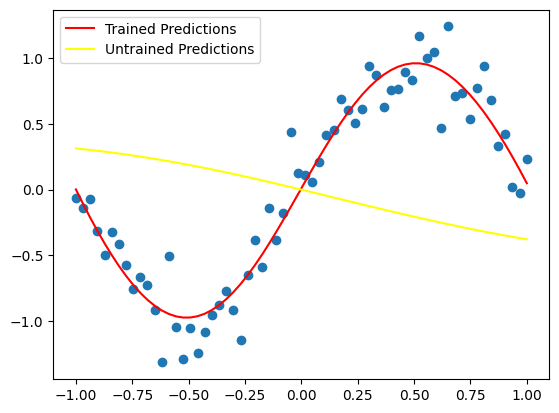

In [8]:
#@title Plot the predictions vs the actual data
plt.scatter(inputs,targets)
plt.plot(inputs,wide_net(inputs).detach(),c='red',label='Trained Predictions')
new_wn = WideNet()
plt.plot(inputs,new_wn(inputs).detach(),c = 'yellow',label = 'Untrained Predictions')
plt.legend()
plt.show()

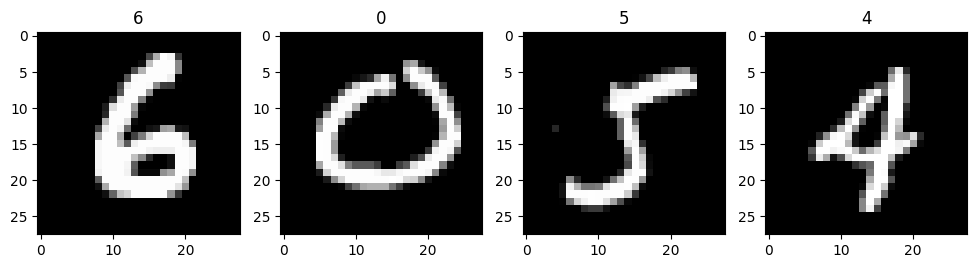

In [2]:
mnist = datasets.MNIST('./mnist/',
                       train = True,
                       transform = transforms.ToTensor(),
                       download = False)
mnist_val = datasets.MNIST('./mnist/',
                       train = False,
                       transform = transforms.ToTensor(),
                       download = False)
data_shape = (1,28,28)
fig, axs = plt.subplots(1,4,figsize=(12,4))
for i in range(4):
  im,label = mnist[random.randint(0,len(mnist))]
  axs[i].imshow(im.squeeze(),cmap='gray')
  axs[i].set_title(label)

In [3]:
nn.Conv2d

torch.nn.modules.conv.Conv2d

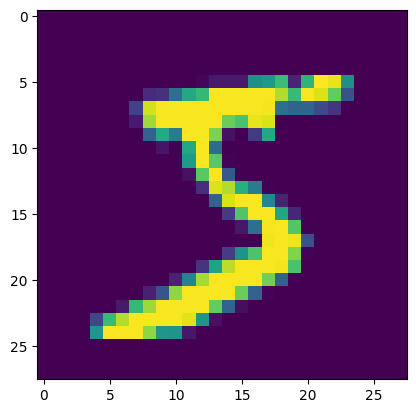

In [4]:
plt.imshow(mnist[0][0].squeeze(0))

In [5]:
conv_test = nn.Conv2d(in_channels=1,out_channels=12,kernel_size = 5,
                      padding = 0)
image = mnist[0][0].unsqueeze(0)
print('Input shape: ',image.shape)
print('Output shape: ',conv_test(image).shape)

Input shape:  torch.Size([1, 1, 28, 28])
Output shape:  torch.Size([1, 12, 24, 24])


In [6]:
conv_test.weight.shape # 12 filters. each 1x5x5

torch.Size([12, 1, 5, 5])

In [7]:
class MiniCNN(nn.Module):
  def __init__(self):
    super(MiniCNN,self).__init__()
    self.layers = nn.Sequential(
        nn.Conv2d(1,32,3),
        nn.ReLU(),
        nn.Conv2d(32,64,3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(9216,128),
        nn.ReLU(),
        nn.Linear(128,10),
    )

  def forward(self,x):
    return self.layers(x)

In [8]:
train_loader = DataLoader(mnist,batch_size=16,shuffle=True)
model = MiniCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
for epoch in range(2):
  print(f'Epoch {epoch}')
  for data, target in tqdm(train_loader,unit='batch'):
    data,target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output,target)
    loss.backward()
    optimizer.step()


Epoch 0


  0%|          | 0/3750 [00:00<?, ?batch/s]

Epoch 1


  0%|          | 0/3750 [00:00<?, ?batch/s]

In [9]:
#@title Evaluation
correct = 0
total = len(mnist_val)
test_loader = DataLoader(mnist_val,batch_size=16,shuffle=True)
with torch.no_grad():
  for data, labels in tqdm(test_loader):
    data,labs = data.to(device),labels.to(device)
    y = model(data)
    predictions = torch.argmax(y,dim=1)
    correct+=torch.sum((predictions == labs).float())
print(f'Test accuracy : {correct/total * 100:.2f}%')

  0%|          | 0/625 [00:00<?, ?it/s]

Test accuracy : 96.91%


In [10]:
vgg = vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 96.0MB/s]


In [11]:
class VGGFeatureExtractor(nn.Module):
  def __init__(self, vggModel, layerIndices):
    super(VGGFeatureExtractor,self).__init__()
    self.features = vggModel.features
    self.layerIndices = layerIndices
    self.outputCount = len(layerIndices)
    for p in self.parameters():
      p.requries_grad = False

  def forward(self,x):
    output = list()
    for i, layer in enumerate(self.features.children()):
      x = layer(x)
      if i in self.layerIndices:
        output.append(x)
        if i == self.layerIndices[-1]:
          return output
    return output



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 56693  100 56693    0     0   174k      0 --:--:-- --:--:-- --:--:--  174k


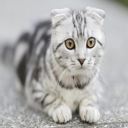

In [12]:
#@title content image
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
content_image = Image.open('cat.jpeg').resize((128,128))
content_image

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  190k  100  190k    0     0   208k      0 --:--:-- --:--:-- --:--:--  207k


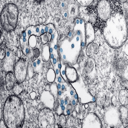

In [13]:
!curl --output style.jpeg "https://images.pexels.com/photos/3992944/pexels-photo-3992944.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
style_image = Image.open('style.jpeg').resize((128,128))
style_image

In [14]:
def pil_to_torch(im):
  return torch.tensor(np.array(im)/255.,dtype =torch.float).permute(2,0,1).unsqueeze(0)

In [15]:
content_im_tensor = pil_to_torch(content_image)
contentExtractor = VGGFeatureExtractor(vgg,  [15, 19])
target_content_features = contentExtractor(content_im_tensor)
# View the shapes of the extracted features (one tensor for each layer):
[t.shape for t in target_content_features]

[torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])]

In [16]:
styleExtractor = VGGFeatureExtractor(vgg,[5, 7, 10, 12, 17])
style_im_tensor = pil_to_torch(style_image)
target_style_features = styleExtractor(style_im_tensor)
[t.shape for t in target_style_features]

[torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16])]

In [17]:
def content_loss(im, target_content_features):
  im_content_features = contentExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_content_features, target_content_features):
    loss += nn.L1Loss()(im_features, target_features)
  return loss/len(im_content_features)

im = torch.rand(1, 3, 128, 128)
content_loss(im, target_content_features)


tensor(2.6743, grad_fn=<DivBackward0>)

In [18]:
# The gram matrix
def gram(x):
	b,c,h,w = x.size();
	x = x.view(b*c, -1);
	return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers

def style_loss(im, target_style_features):
  im_style_features = styleExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_style_features, target_style_features):
    im_gram = gram(im_features)
    target_gram = gram(target_features)
    loss += F.mse_loss(im_gram, target_gram);
  return loss/len(im_style_features)

style_loss(im, target_style_features)

tensor(200.2439, grad_fn=<DivBackward0>)

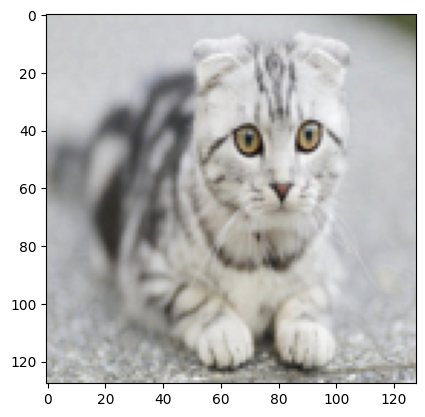

42.5328369140625


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [19]:
im = pil_to_torch(content_image)
im.requires_grad = True

optimizer = torch.optim.AdamW([im],lr =5e-3)
style_weight, content_weight =0.5,1
losses = []
for i in range(75):
  optimizer.zero_grad()
  loss = style_weight * style_loss(im.clip(0,1), target_style_features)
  loss += content_weight * content_loss(im.clip(0,1),target_content_features)
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  if i%25 ==0:
    with torch.no_grad():
      plt.imshow(im.clip(0,1).detach().squeeze().permute(1,2,0))
      plt.show()
      print(loss.item())

plt.plot(losses)

In [ ]:
!curl --output fire.jpeg "https://images.pexels.com/photos/207353/pexels-photo-207353.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1" > /dev/null

In [ ]:
#@title Style Transfer

width = 128 #@param
height = 128 #@param
style_image_path = 'fire.jpeg' #@param
style_image = Image.open(style_image_path).resize((width,height))
content_image_path = 'cat.jpeg' #@param
content_image = Image.open(content_image_path).resize((width, height))

content_layers = [19] #@param
contentExtractor = VGGFeatureExtractor(vgg,content_layers).to(device)
content_im_tensor = pil_to_torch(content_image).to(device)
target_content_features = contentExtractor(content_im_tensor)

style_layers = [5,7,10,12,17] #@param
styleExtractor = VGGFeatureExtractor(vgg,style_layers).to(device)
style_im_tensor = pil_to_torch(style_image).to(device)
target_style_features = styleExtractor(style_im_tensor)

im = pil_to_torch(content_image).to(device)
im.requires_grad = True

tfms = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
])

lr = 0.01 #@param
optimizer = torch.optim.AdamW([im],lr=lr)

style_weight = 0.1 #@param
content_weight = 0.9 #@param
n_tfms = 4 #@param

fig,axs = plt.subplots(1,4,figsize=(16,4))
p = display(fig,display_id=True)
losses = []
n_iter = 50 #@param
for i in range(n_iter):
  optimizer.zero_grad()
  loss = 0
  for i in range(n_tfms):
    loss+= style_weight * style_loss(tfms(im.clip(0,1)),target_style_features)
    loss+= content_weight * content_loss(tfms(im.clip(0,1)),target_content_features)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())
  if i % 3 ==0:
    with torch.no_grad():
      axs[0].plot(losses, label='Loss:'+str(loss.item()))
      axs[1].imshow(im.clip(0, 1).detach().cpu().squeeze().permute(1, 2, 0))
      axs[2].imshow(content_image)
      axs[3].imshow(style_image)
      p.update(fig)

ipd.clear_output()
p.update(fig)



In [20]:
#@title Auto Encoders
class ConvAE(nn.Module):
  def __init__(self,hdim=20):
    super(ConvAE,self).__init__()
    self.enc_conv1 = nn.Conv2d(1,32,3)
    self.enc_conv2 = nn.Conv2d(32,32,3)
    self.enc_fc1 = nn.Linear(32*24*24,128)
    self.enc_fc2 = nn.Linear(128,hdim)

    self.dec_fc1 = nn.Linear(hdim,128)
    self.dec_fc2 = nn.Linear(128,32*24*24)
    self.dec_unflatten = nn.Unflatten(dim=-1,unflattened_size=(32,24,24))
    self.dec_conv1 = nn.ConvTranspose2d(32,32,3)
    self.dec_conv2 = nn.ConvTranspose2d(32,1,3)

  def encode(self,x):
    x = self.enc_conv1(x)
    x = F.relu(x)
    x = self.enc_conv2(x)
    x = F.relu(x)
    x = torch.flatten(x,1)
    x = self.enc_fc1(x)
    x = F.relu(x)
    x = self.enc_fc2(x)
    return x

  def decode(self,x):
    x = self.dec_fc1(x)
    x = F.relu(x)
    x = self.dec_fc2(x)
    x = F.relu(x)
    x = self.dec_unflatten(x)
    x = self.dec_conv1(x)
    x = F.relu(x)
    x = self.dec_conv2(x)
    return x

  def forward(self, x):
    return self.decode(self.encode(x))


torch.Size([1, 20])
torch.Size([1, 1, 28, 28])


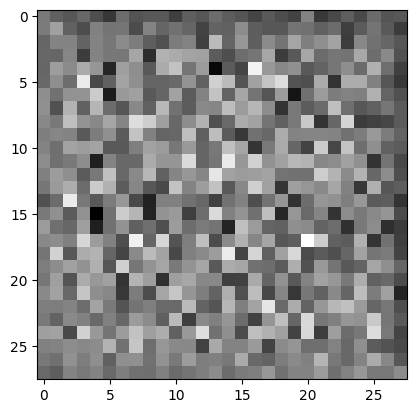

In [21]:
ae = ConvAE()
encoded = ae.encode(mnist[0][0].unsqueeze(0))
print(encoded.shape)
decoded = ae.decode(encoded)
print(decoded.shape)
plt.imshow(decoded.detach().squeeze(), cmap='gray')

In [22]:
def train_autoencoder(autoencoder,dataset,device,epochs=20,batch_size=250,seed=0):
  autoencoder.to(device)
  optim = torch.optim.Adam(autoencoder.parameters(),lr=1e-3,weight_decay=1e-5)
  loss_fn = nn.MSELoss()
  g_seed = torch.Generator()
  loader = DataLoader(dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      pin_memory=True,
                      num_workers=2,
                      generator=g_seed)
  mse_loss = torch.zeros(epochs * len(dataset) // batch_size,device = device)
  i = 0
  for epoch in tqdm(range(epochs)):
    for im_batch, _ in loader:
      im_batch = im_batch.to(device)
      optim.zero_grad()
      reconstruction = autoencoder(im_batch)
      loss = loss_fn(reconstruction.view(batch_size,-1),target = im_batch.view(batch_size,-1))
      loss.backward()
      optim.step()
      mse_loss[i] = loss.detach()
      i+=1

train_autoencoder(ae,mnist,device)


  0%|          | 0/20 [00:00<?, ?it/s]

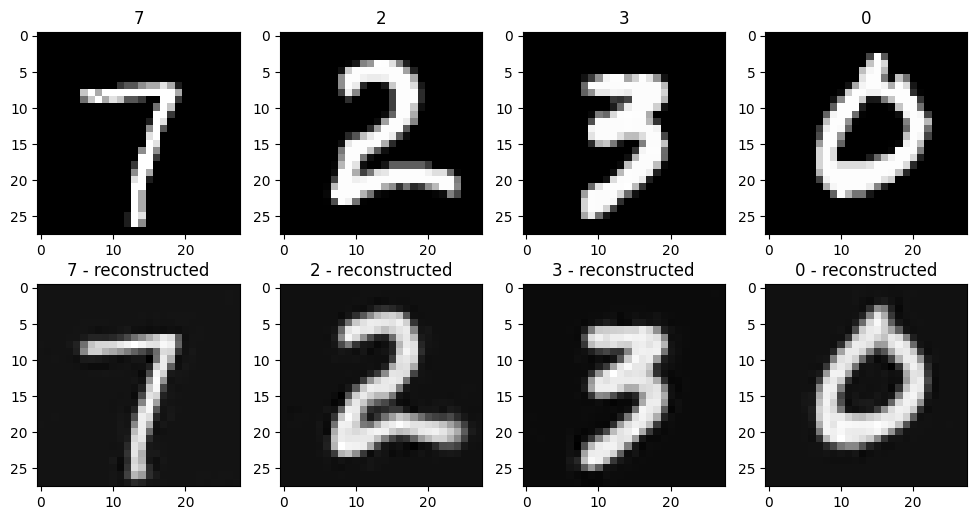

In [23]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(4):
  im, label = mnist_val[random.randint(0, len(mnist_val))]
  axs[0][i].imshow(im.squeeze(), cmap='gray')
  axs[0][i].set_title(label)
  axs[1][i].imshow(ae(im.unsqueeze(0).to(device)).squeeze().detach().cpu(), cmap='gray')
  axs[1][i].set_title(str(label) + ' - reconstructed')

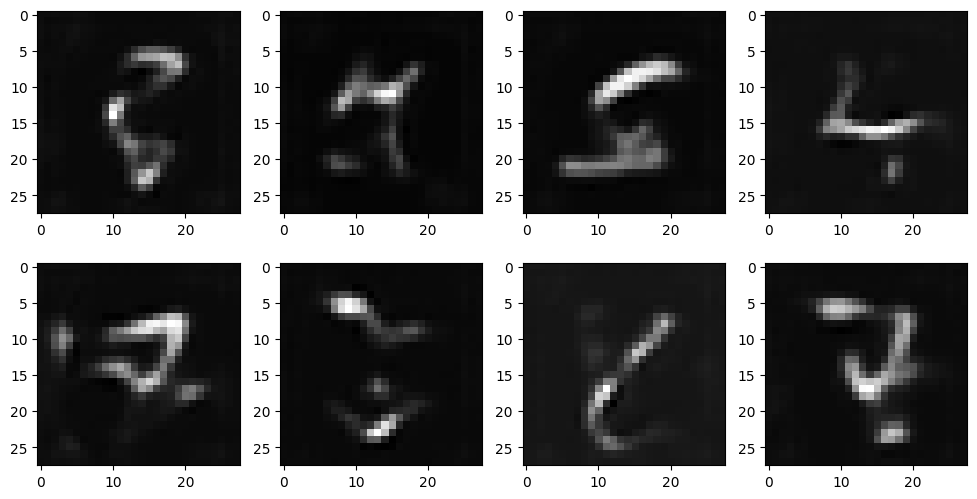

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
  im = ae.decode(torch.randn(1, 20).to(device))
  axs[i//4][i%4].imshow(im.detach().cpu().squeeze(), cmap='gray')